# Minimal Evaluation Demo 

In [ ]:
import numpy as np
from utils.equirectangular_render import *
from utils.eval_depth import *
import glob

ply_path = f'/path/to/reconstructed/mesh.ply'
camera_path = sorted(glob.glob('/path/to/OB3D//barbershop/Egocentric/cameras/*.json'))[0]
gt_depth_path = sorted(glob.glob('/path/to/OB3D//barbershop/Egocentric/depths/*.exr'))[0]
depth_map, normal_map = equirectangular_renderer_from_mesh(ply_path, camera_path, width=1600, height=800)
depth_map_gt = np.array(read_exr_depth(gt_depth_path)).astype(np.float32)
depth_metrics = calculate_metrics(depth_map, depth_map_gt, depth_max_value=8.0)
print(depth_metrics)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
{'RMSE': 0.3180845193985749, 'MAE': 0.0556211305111213, 'RMSE_scale_invariant': 0.8884771177201295, 'Percentage_within_threshold_1.25': 0.9873894180531012, 'MSE': 0.10117776148102238, 'RMSE_log': 0.8902426313310557, 'Abs_relative_difference': 0.024626832640050927, 'Squared_relative_difference': 0.027504740569613773}


# Visualize Rendered RGB, Depth, Normal from Mesh

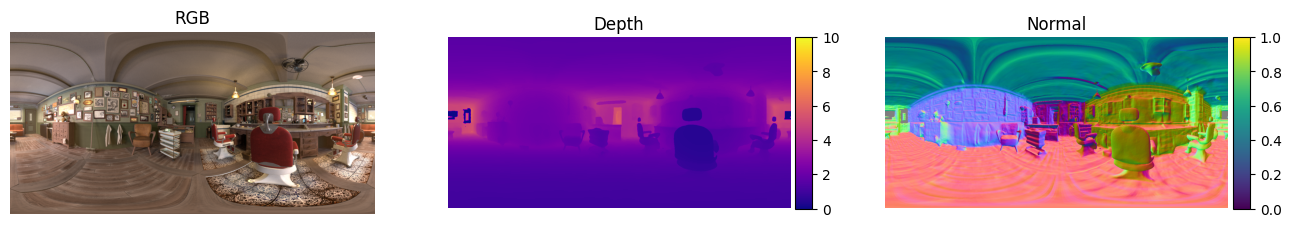

In [ ]:
from PIL import Image
from utils.visualize import visualize_rgb_depth_normal
gt_rgb_path = sorted(glob.glob('/path/to/OB3D/barbershop/Egocentric/images/*.png'))[0]
rgb = np.array(Image.open(gt_rgb_path))
visualize_rgb_depth_normal(rgb, depth_map, normal_map, visualize_depth_max=10.0)

# Evaluate the average over all viewpoints used for training

Total number of views: 25
Picked views: [0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76, 80, 84, 88, 92, 96]
----- View idx: 0 -----


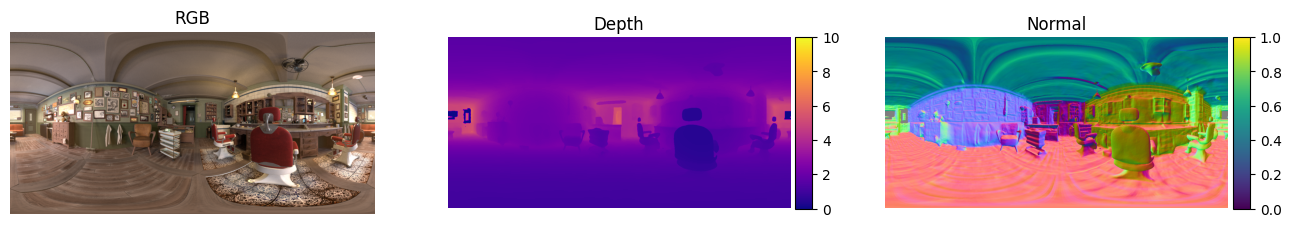

RMSE: 0.318971
MAE: 0.056855
RMSE_scale_invariant: 0.922404
Percentage_within_threshold_1.25: 0.990580
MSE: 0.101758
RMSE_log: 0.924805
Abs_relative_difference: 0.024084
Squared_relative_difference: 0.022559
Metrics saved to ./metrics/NeuS_demo
Demo mode: stopping after the evaluation of a first scene.


In [ ]:
method = "NeuS"
view_interval = 4
is_demo = True

# scene name and max depth value
scene_dict = {
    "barbershop": 10,
    "archiviz-flat": 20,
    "bistro": 50,
    "classroom": 15,
    "EmeraldSquare": 70,
    "fisher-hut": 70,
    "lone-monk": 25,
    "restroom": 20,
    "san-miguel": 20,
    "sponza": 20,
    "sun_temple": 20,
    "pavillion": 50,
}

capture_types = ["Egocentric", "Non-Egocentric"]

for scene, depth_max_value in scene_dict.items():
    for capture_type in capture_types:
        base_data_dir = f'/path/to/OB3D/{scene}/{capture_type}'

        ply_path = f'/path/to/OB3D/{scene}/{capture_type}/mesh.ply'

        camera_path_list = sorted(glob.glob(os.path.join(base_data_dir, 'cameras/*.json')))
        gt_rgb_path_list = sorted(glob.glob(os.path.join(base_data_dir, 'images/*.png')))
        gt_depth_path_list = sorted(glob.glob(os.path.join(base_data_dir, 'depths/*.exr')))

        print(f"Total number of views: {len(range(0, len(camera_path_list), view_interval))}")
        print(f"Picked views: {list(range(0, len(camera_path_list), view_interval))}")

        all_depth_metrics = []
        for i in range(0, len(camera_path_list), view_interval):
            camera_path = camera_path_list[i]
            gt_rgb_path = gt_rgb_path_list[i]
            gt_depth_path = gt_depth_path_list[i]

            depth_map, normal_map = equirectangular_renderer_from_mesh(ply_path, camera_path, width=1600, height=800)

            # visualize rendered depth map and normal map
            if i == 0:
                rgb = np.array(Image.open(gt_rgb_path))
                print(f"----- View idx: {i} -----")
                visualize_rgb_depth_normal(rgb, depth_map, normal_map, visualize_depth_max=depth_max_value)

            depth_map_gt = np.array(read_exr_depth(gt_depth_path)).astype(np.float32)
            depth_metrics = calculate_metrics(depth_map, depth_map_gt, depth_max_value=depth_max_value)
            all_depth_metrics.append(depth_metrics)
        
        from collections import defaultdict
        values = defaultdict(list)
        for entry in all_depth_metrics:
            for key, val in entry.items():
                if not np.isnan(val) and not np.isinf(val):
                    values[key].append(val)

        # calculate the average of each metric
        averages = {key: np.mean(vals) for key, vals in values.items()}
        for key, val in averages.items():
            print(f"{key}: {val:.6f}")

        # save the metrics to a JSON file
        save_dir = f"./metrics/{method}_demo"
        os.makedirs(save_dir, exist_ok=True)
        with open(os.path.join(save_dir, f"{scene}_{capture_type}_depth_metrics.json"), 'w') as f:
            json.dump(averages, f, indent=4)
        print(f"Metrics saved to {save_dir}")

        
        if is_demo:
            break
    if is_demo:
        print("Demo mode: stopping after the evaluation of a first scene.")
        break
